In [208]:
import polars as pl
df = pl.read_csv("../data/data.csv")

In [209]:
print(df.columns)
print(df.dtypes)

['', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
[Int64, String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64]


# Intervalos anómalos

In [210]:
import datetime 

anomalies = [
    (datetime.datetime(2020, 4, 12, 11, 50), datetime.datetime(2020, 4, 12, 23, 30)),
    (datetime.datetime(2020, 4, 18, 0, 0), datetime.datetime(2020, 4, 18, 23, 59)),
    (datetime.datetime(2020, 4, 19, 0, 0), datetime.datetime(2020, 4, 19, 1, 30)),
    (datetime.datetime(2020, 4, 29, 3, 20), datetime.datetime(2020, 4, 29, 4, 0)),
    (datetime.datetime(2020, 4, 29, 22, 0), datetime.datetime(2020, 4, 29, 22, 20)),
    (datetime.datetime(2020, 5, 13, 14, 0), datetime.datetime(2020, 5, 13, 23, 59)),
    (datetime.datetime(2020, 5, 18, 5, 0), datetime.datetime(2020, 5, 18, 5, 30)),
    (datetime.datetime(2020, 5, 19, 10, 10), datetime.datetime(2020, 5, 19, 11, 0)),
    (datetime.datetime(2020, 5, 19, 22, 10), datetime.datetime(2020, 5, 19, 23, 59)),
    (datetime.datetime(2020, 5, 20, 0, 0), datetime.datetime(2020, 5, 20, 20, 0)),
    (datetime.datetime(2020, 5, 23, 9, 50), datetime.datetime(2020, 5, 23, 10, 10)),
    (datetime.datetime(2020, 5, 29, 23, 30), datetime.datetime(2020, 5, 29, 23, 59)),
    (datetime.datetime(2020, 5, 30, 0, 0), datetime.datetime(2020, 5, 30, 6, 0)),
    (datetime.datetime(2020, 6, 1, 15, 0), datetime.datetime(2020, 6, 1, 15, 40)),
    (datetime.datetime(2020, 6, 3, 10, 0), datetime.datetime(2020, 6, 3, 11, 0)),
    (datetime.datetime(2020, 6, 5, 10, 0), datetime.datetime(2020, 6, 5, 23, 59)),
    (datetime.datetime(2020, 6, 6, 0, 0), datetime.datetime(2020, 6, 6, 23, 59)),
    (datetime.datetime(2020, 6, 7, 0, 0), datetime.datetime(2020, 6, 7, 14, 30)),
    (datetime.datetime(2020, 7, 8, 17, 30), datetime.datetime(2020, 7, 8, 19, 0)),
    (datetime.datetime(2020, 7, 15, 14, 30), datetime.datetime(2020, 7, 15, 19, 0)),
    (datetime.datetime(2020, 7, 17, 4, 30), datetime.datetime(2020, 7, 17, 5, 30)),
]


raros = [
    #NO APARECE COMO ANOMALIA
    (datetime.datetime(2020, 3, 6, 21, 42, 15), datetime.datetime(2020, 3, 6, 23, 14, 0)),
    (datetime.datetime(2020, 3, 11, 5, 15, 10), datetime.datetime(2020, 3, 11, 6, 25, 0)),
    (datetime.datetime(2020, 3, 12, 0, 15, 56), datetime.datetime(2020, 3, 12, 11, 59, 0)),
    (datetime.datetime(2020, 3, 26, 4, 0, 20), datetime.datetime(2020, 3, 26, 5, 20, 0)),
    (datetime.datetime(2020, 3, 27, 7, 12, 0), datetime.datetime(2020, 3, 27, 12, 1, 0)),
    (datetime.datetime(2020, 4, 17, 8, 50, 28), datetime.datetime(2020, 4, 17, 23, 59, 0)),
    (datetime.datetime(2020, 4, 25, 0, 7, 15), datetime.datetime(2020, 4, 25, 1, 10, 0)),
    (datetime.datetime(2020, 5, 19, 1, 35, 28), datetime.datetime(2020, 5, 19, 2, 40, 0)),
    (datetime.datetime(2020, 6, 12, 1, 41, 7), datetime.datetime(2020, 6, 12, 17, 6, 0)),
    (datetime.datetime(2020, 7, 21, 13, 32, 48), datetime.datetime(2020, 7, 21, 22, 3, 0)),
    (datetime.datetime(2020, 7, 22, 6, 40, 46), datetime.datetime(2020, 7, 22, 13, 10, 0)),
    (datetime.datetime(2020, 7, 31, 0, 57, 33), datetime.datetime(2020, 7, 31, 2, 9, 0))
]

anomalies.extend(raros)

# Correción de periodos temporales.
final_anomalies = []
for anomaly in anomalies: 
  new = list(anomaly)
  if anomaly[1].minute == 59:
    new[1] += datetime.timedelta(minutes=1)
  final_anomalies.append(new)

In [211]:
import datetime
df = df.with_columns(pl.col("timestamp").str.to_datetime())
df = df.with_row_index("rownr")

In [212]:
anomalies[1][1] + datetime.timedelta(seconds=59)

datetime.datetime(2020, 4, 18, 23, 59, 59)

# Definimos las anomalias

In [213]:
def is_anomaly(instance_date, anomalies: list[datetime]):
    flag_anomaly = False
    index = 0
    while not flag_anomaly and index < len(anomalies):
        t = anomalies[index]
        if instance_date >= t[0] and instance_date <= t[1] + datetime.timedelta(seconds=59):
            flag_anomaly = True
        index += 1
    return flag_anomaly


df = df.select(pl.all(), pl.lit(0).alias("is_anomaly"))
for anomaly in final_anomalies:
  df = df.with_columns((pl.col("is_anomaly") + df["timestamp"].is_between(anomaly[0], anomaly[1])))
df = df.select(pl.exclude("is_anomaly"), pl.col("is_anomaly") >= 1)
# df = df.select(pl.all(), pl.col("timestamp").map_elements(lambda x: is_anomaly(x, anomalies), return_dtype=pl.Boolean).alias("is_anomaly"))

# Justificamos el cálculo de la ventana

In [214]:
# Create transition states
tdf = df.select(pl.all(), pl.col("is_anomaly").shift(-1).alias("next_is_anomaly"), pl.col("Motor_current").gt(0.05).alias("motor_state"))
tdf = tdf.select(pl.all(), (pl.col("is_anomaly") != pl.col("next_is_anomaly")).alias("transition"))
tdf

shape: (1_516_948, 22)
┌─────────┬──────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ rownr   ┆          ┆ timestamp  ┆ TP2    ┆ … ┆ is_anomaly ┆ next_is_an ┆ motor_stat ┆ transition │
│ ---     ┆ ---      ┆ ---        ┆ ---    ┆   ┆ ---        ┆ omaly      ┆ e          ┆ ---        │
│ u32     ┆ i64      ┆ datetime[μ ┆ f64    ┆   ┆ bool       ┆ ---        ┆ ---        ┆ bool       │
│         ┆          ┆ s]         ┆        ┆   ┆            ┆ bool       ┆ bool       ┆            │
╞═════════╪══════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0        ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:00   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1       ┆ 10       ┆ 2020-02-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:10   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2       ┆ 20       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:19   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 3       ┆ 30       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:29   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 4       ┆ 40       ┆ 2020-02-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 00:00:39   ┆        ┆   ┆            ┆            ┆            ┆            │
│ …       ┆ …        ┆ …          ┆ …      ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 1516943 ┆ 15169430 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:10   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516944 ┆ 15169440 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:20   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516945 ┆ 15169450 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:30   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516946 ┆ 15169460 ┆ 2020-09-01 ┆ -0.012 ┆ … ┆ false      ┆ false      ┆ false      ┆ false      │
│         ┆          ┆ 03:59:40   ┆        ┆   ┆            ┆            ┆            ┆            │
│ 1516947 ┆ 15169470 ┆ 2020-09-01 ┆ -0.014 ┆ … ┆ false      ┆ null       ┆ false      ┆ null       │
│         ┆          ┆ 03:59:50   ┆        ┆   ┆            ┆            ┆            ┆            │
└─────────┴──────────┴────────────┴────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [215]:
# Create groups based on transition
tdf = tdf.select(pl.all(), pl.col("transition").cum_sum().alias("groups"))
tdf["groups"].max()

54

In [216]:
gdf = tdf.select(pl.all(), pl.col("groups").shift(-1).alias("next_group"), pl.col("motor_state").shift(-1).alias("next_motor_state"))
# Filter a ON switch
fdf = gdf.filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1)).with_columns(pl.col("timestamp").shift(-1).alias("next_timestamp"))
# Filter out different time groups
fdf = fdf.filter(pl.col("groups") == pl.col("next_group"))
# Calculate the duration
fdf = fdf.with_columns((pl.col("next_timestamp") - pl.col("timestamp")).alias("duration")).filter(pl.col("duration").is_not_null())
print(fdf["duration"].dt.total_seconds().max(), fdf["duration"].dt.total_seconds().min(), fdf["duration"].dt.total_seconds().mean(), fdf["duration"].dt.total_seconds().mode()[0])

274751 19 1771.898393149235 1249


In [217]:
fdf.filter(pl.col("duration").eq(pl.col("duration").max()))

shape: (1, 27)
┌────────┬─────────┬─────────────┬────────┬───┬────────────┬─────────────┬────────────┬────────────┐
│ rownr  ┆         ┆ timestamp   ┆ TP2    ┆ … ┆ next_group ┆ next_motor_ ┆ next_times ┆ duration   │
│ ---    ┆ ---     ┆ ---         ┆ ---    ┆   ┆ ---        ┆ state       ┆ tamp       ┆ ---        │
│ u32    ┆ i64     ┆ datetime[μs ┆ f64    ┆   ┆ u32        ┆ ---         ┆ ---        ┆ duration[μ │
│        ┆         ┆ ]           ┆        ┆   ┆            ┆ bool        ┆ datetime[μ ┆ s]         │
│        ┆         ┆             ┆        ┆   ┆            ┆             ┆ s]         ┆            │
╞════════╪═════════╪═════════════╪════════╪═══╪════════════╪═════════════╪════════════╪════════════╡
│ 890739 ┆ 8907390 ┆ 2020-06-05  ┆ -0.014 ┆ … ┆ 38         ┆ true        ┆ 2020-06-08 ┆ 3d 4h 19m  │
│        ┆         ┆ 09:48:20    ┆        ┆   ┆            ┆             ┆ 14:07:31   ┆ 11s        │
└────────┴─────────┴─────────────┴────────┴───┴────────────┴─────────────┴────────────┴────────────┘

In [218]:
import plotly.express as px
data_anomaly = df.filter(pl.col("timestamp").is_between(
datetime.datetime(2020,6,5,00,00,00), datetime.datetime(2020,6,8,15,00,00)
))
px.line(data_anomaly, x="timestamp", y=["TP3", "Motor_current"])

In [219]:
data_anomaly.select(pl.col("is_anomaly"), pl.col("is_anomaly").shift(-1).alias("next_is_anomaly"), pl.col("timestamp"), pl.col("timestamp").shift(-1).alias("next_timestamp")).filter(~pl.col("is_anomaly").eq(pl.col("next_is_anomaly")))

shape: (2, 4)
┌────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ is_anomaly ┆ next_is_anomaly ┆ timestamp           ┆ next_timestamp      │
│ ---        ┆ ---             ┆ ---                 ┆ ---                 │
│ bool       ┆ bool            ┆ datetime[μs]        ┆ datetime[μs]        │
╞════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ false      ┆ true            ┆ 2020-06-05 09:59:54 ┆ 2020-06-05 10:00:04 │
│ true       ┆ false           ┆ 2020-06-07 14:19:39 ┆ 2020-06-08 11:48:04 │
└────────────┴─────────────────┴─────────────────────┴─────────────────────┘

## Para cada grupo

In [220]:
gdf = tdf.select(pl.all(), pl.col("groups").shift(-1).alias("next_group"), pl.col("motor_state").shift(-1).alias("next_motor_state"))
# Filter a ON switch
durations = []
for label, group in gdf.filter(pl.col("groups") == pl.col("next_group")).group_by("groups"):
  tmp = group.filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1)).with_columns(pl.col("timestamp").shift(-1).alias("next_timestamp"))
  tmp = tmp.with_columns((pl.col("next_timestamp") - pl.col("timestamp")).alias("duration")).filter(pl.col("duration").is_not_null())
  durations += tmp["duration"].to_list()
durations = [x.total_seconds() for x in durations]
print(max(durations), min(durations), sum(durations) / len(durations), durations[len(durations)//2])

224082.0 19.0 1695.8500048323185 1170.0


## Para el primer tramo no-anómalo

In [221]:
subdf = df.filter(pl.col("timestamp").lt(anomalies[0][0]))
subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))["timestamp"].diff().dt.total_seconds().mode()[0]

1586

## Para cada grupo evitando saltos temporales

In [222]:
durations = []
subdf = df.filter(pl.col("timestamp").lt(final_anomalies[0][0]))
subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
print(len(durations), len(subdf))
durations += subdf["duration"].to_list()
for anomaly, next_anomaly, next_next_anomaly in zip(final_anomalies, final_anomalies[1:], final_anomalies[2:]):
  subdf = df.filter(
    (pl.col("timestamp").lt(next_anomaly[0]) & (pl.col("timestamp").gt(anomaly[1])))
  )
  subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
  subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
  subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
  print(len(durations), len(subdf))
  durations += subdf["duration"].to_list()
  subdf = df.filter(
    (pl.col("timestamp").gt(next_anomaly[1]) & (pl.col("timestamp").lt(next_next_anomaly[0])))
  )
  subdf = subdf.with_columns(pl.col("Motor_current").lt(0.05).alias("motor_state"))
  subdf = subdf.with_columns(pl.col("motor_state").shift(-1).alias("next_motor_state")).filter((pl.col("motor_state") == 0) & (pl.col("next_motor_state") == 1))
  subdf = subdf.with_columns(pl.col("timestamp").diff().dt.total_seconds().alias("duration")).filter(pl.col("duration").is_not_null())
  print(len(durations), len(subdf))
  durations += subdf["duration"].to_list()
print(max(durations), min(durations), sum(durations) / len(durations), sorted(durations)[len(durations)//2])

0 3165
3165 147
3312 0
3312 0
3312 311
3623 311
3934 38
3972 38
4010 515
4525 515
5040 182
5222 182
5404 100
5504 100
5604 43
5647 43
5690 0
5690 0
5690 193
5883 193
6076 269
6345 269
6614 0
6614 0
6614 145
6759 145
6904 83
6987 83
7070 115
7185 115
7300 0
7300 0
7300 0
7300 0
7300 1745
9045 1745
10790 379
11169 379
11548 97
11645 97
11742 0
11742 0
11742 230
11972 230
12202 22
12224 22
12246 612
12858 612
13470 53
13523 53
13576 802
14378 802
15180 230
15410 230
15640 902
16542 902
17444 1106
18550 1106
19656 2316
21972 2316
24288 24
24312 24
24336 518
274930 20 1781.5975698076768 1289


In [223]:
df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))

In [224]:
# df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))
df = df.with_columns((pl.col("diff").dt.total_seconds() // (1260 * 2)).alias("id"))
df = df.with_columns(pl.col("id").cast(pl.UInt64).alias("id"))

In [225]:
df.group_by("id", maintain_order=True).len()

shape: (6_232, 2)
┌──────┬─────┐
│ id   ┆ len │
│ ---  ┆ --- │
│ u64  ┆ u32 │
╞══════╪═════╡
│ null ┆ 1   │
│ 0    ┆ 254 │
│ 1    ┆ 254 │
│ 2    ┆ 254 │
│ 3    ┆ 255 │
│ …    ┆ …   │
│ 7297 ┆ 129 │
│ 7303 ┆ 30  │
│ 7306 ┆ 101 │
│ 7307 ┆ 254 │
│ 7308 ┆ 145 │
└──────┴─────┘

In [226]:
import plotly.express as px
import pandas as pd
start = 51000
end = 51000 + 10000
df = df.sort("timestamp")
px.line(df[start : end], x="timestamp", y="TP3", color="id")

Tendríamos que imputar solamente aquellos tramos cuya distancia fuera casi insignificante (algunos minutos). 
Ya que si observamos el Feb-9T00:00 a Feb-9T06:00 hemos introducido una línea similar a lo que seŕia una anomalía por el tamaño del salto temporal.

Otra opción sería investigar introducir segmentos cíclicos hasta que la diferencia fuera manejable. No obstante, esto sería difícil de argumentar y confuso para los posibles segmentos anómalos. 

## Observar valores faltantes

In [227]:
with pl.Config(tbl_rows=1000):
  print(df.filter(pl.col("timestamp").gt(datetime.datetime(2020,2, 1, 19, 40, 00)) & pl.col("timestamp").lt(datetime.datetime(2020, 2, 2, 6, 00, 00))))

shape: (549, 21)
┌───────┬───────┬─────────────────┬────────┬───┬────────────────┬────────────┬───────────────┬─────┐
│ rownr ┆       ┆ timestamp       ┆ TP2    ┆ … ┆ Caudal_impulse ┆ is_anomaly ┆ diff          ┆ id  │
│ ---   ┆ ---   ┆ ---             ┆ ---    ┆   ┆ s              ┆ ---        ┆ ---           ┆ --- │
│ u32   ┆ i64   ┆ datetime[μs]    ┆ f64    ┆   ┆ ---            ┆ bool       ┆ duration[μs]  ┆ u64 │
│       ┆       ┆                 ┆        ┆   ┆ f64            ┆            ┆               ┆     │
╞═══════╪═══════╪═════════════════╪════════╪═══╪════════════════╪════════════╪═══════════════╪═════╡
│ 7113  ┆ 71130 ┆ 2020-02-01      ┆ -0.012 ┆ … ┆ 1.0            ┆ false      ┆ 19h 40m 4s    ┆ 28  │
│       ┆       ┆ 19:40:04        ┆        ┆   ┆                ┆            ┆               ┆     │
│ 7114  ┆ 71140 ┆ 2020-02-01      ┆ -0.018 ┆ … ┆ 1.0            ┆ false      ┆ 23h 15m 33s   ┆ 33  │
│       ┆       ┆ 23:15:33        ┆        ┆   ┆                ┆         

In [228]:
df.filter(pl.col("timestamp").diff().dt.total_seconds().gt(10))

shape: (51_147, 21)
┌─────────┬──────────┬──────────────┬────────┬───┬──────────────┬────────────┬──────────────┬──────┐
│ rownr   ┆          ┆ timestamp    ┆ TP2    ┆ … ┆ Caudal_impul ┆ is_anomaly ┆ diff         ┆ id   │
│ ---     ┆ ---      ┆ ---          ┆ ---    ┆   ┆ ses          ┆ ---        ┆ ---          ┆ ---  │
│ u32     ┆ i64      ┆ datetime[μs] ┆ f64    ┆   ┆ ---          ┆ bool       ┆ duration[μs] ┆ u64  │
│         ┆          ┆              ┆        ┆   ┆ f64          ┆            ┆              ┆      │
╞═════════╪══════════╪══════════════╪════════╪═══╪══════════════╪════════════╪══════════════╪══════╡
│ 4654    ┆ 46540    ┆ 2020-02-01   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 12h 53m 47s  ┆ 18   │
│         ┆          ┆ 12:53:47     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 7114    ┆ 71140    ┆ 2020-02-01   ┆ -0.018 ┆ … ┆ 1.0          ┆ false      ┆ 23h 15m 33s  ┆ 33   │
│         ┆          ┆ 23:15:33     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 7144    ┆ 71440    ┆ 2020-02-02   ┆ 9.952  ┆ … ┆ 1.0          ┆ false      ┆ 1d 4h 34m    ┆ 40   │
│         ┆          ┆ 04:34:27     ┆        ┆   ┆              ┆            ┆ 27s          ┆      │
│ 8254    ┆ 82540    ┆ 2020-02-02   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 1d 7h 41m    ┆ 45   │
│         ┆          ┆ 07:41:52     ┆        ┆   ┆              ┆            ┆ 52s          ┆      │
│ 31804   ┆ 318040   ┆ 2020-02-05   ┆ 10.412 ┆ … ┆ 1.0          ┆ false      ┆ 4d 43m       ┆ 138  │
│         ┆          ┆ 00:43:00     ┆        ┆   ┆              ┆            ┆              ┆      │
│ …       ┆ …        ┆ …            ┆ …      ┆ … ┆ …            ┆ …          ┆ …            ┆ …    │
│ 1502468 ┆ 15024680 ┆ 2020-08-30   ┆ 9.264  ┆ … ┆ 1.0          ┆ false      ┆ 211d 4h 26m  ┆ 7240 │
│         ┆          ┆ 04:26:10     ┆        ┆   ┆              ┆            ┆ 10s          ┆      │
│ 1509758 ┆ 15097580 ┆ 2020-08-31   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 212d 1h 49m  ┆ 7271 │
│         ┆          ┆ 01:49:32     ┆        ┆   ┆              ┆            ┆ 32s          ┆      │
│ 1511498 ┆ 15114980 ┆ 2020-08-31   ┆ -0.012 ┆ … ┆ 1.0          ┆ false      ┆ 212d 6h 42m  ┆ 7278 │
│         ┆          ┆ 06:42:31     ┆        ┆   ┆              ┆            ┆ 31s          ┆      │
│ 1516418 ┆ 15164180 ┆ 2020-09-01   ┆ 7.48   ┆ … ┆ 1.0          ┆ false      ┆ 213d 37m 33s ┆ 7303 │
│         ┆          ┆ 00:37:33     ┆        ┆   ┆              ┆            ┆              ┆      │
│ 1516448 ┆ 15164480 ┆ 2020-09-01   ┆ -0.014 ┆ … ┆ 1.0          ┆ false      ┆ 213d 2h 37m  ┆ 7306 │
│         ┆          ┆ 02:37:24     ┆        ┆   ┆              ┆            ┆ 24s          ┆      │
└─────────┴──────────┴──────────────┴────────┴───┴──────────────┴────────────┴──────────────┴──────┘

# Verificar valores raros

In [229]:
px.line(df.filter(pl.col("timestamp").is_between(*raros[5])), x="timestamp", y="TP3", color="id")

# Revisar datos procesados

In [230]:
import polars as pl 

df = pl.read_csv("../data/data.csv")
df

shape: (1_516_948, 17)
┌──────────┬────────────┬────────┬───────┬───┬─────┬─────────────────┬───────────┬─────────────────┐
│          ┆ timestamp  ┆ TP2    ┆ TP3   ┆ … ┆ LPS ┆ Pressure_switch ┆ Oil_level ┆ Caudal_impulses │
│ ---      ┆ ---        ┆ ---    ┆ ---   ┆   ┆ --- ┆ ---             ┆ ---       ┆ ---             │
│ i64      ┆ str        ┆ f64    ┆ f64   ┆   ┆ f64 ┆ f64             ┆ f64       ┆ f64             │
╞══════════╪════════════╪════════╪═══════╪═══╪═════╪═════════════════╪═══════════╪═════════════════╡
│ 0        ┆ 2020-02-01 ┆ -0.012 ┆ 9.358 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:00   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 10       ┆ 2020-02-01 ┆ -0.014 ┆ 9.348 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:10   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 20       ┆ 2020-02-01 ┆ -0.012 ┆ 9.338 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:19   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 30       ┆ 2020-02-01 ┆ -0.012 ┆ 9.328 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:29   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 40       ┆ 2020-02-01 ┆ -0.012 ┆ 9.318 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 00:00:39   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ …        ┆ …          ┆ …      ┆ …     ┆ … ┆ …   ┆ …               ┆ …         ┆ …               │
│ 15169430 ┆ 2020-09-01 ┆ -0.014 ┆ 8.918 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:10   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169440 ┆ 2020-09-01 ┆ -0.014 ┆ 8.904 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:20   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169450 ┆ 2020-09-01 ┆ -0.014 ┆ 8.89  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:30   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169460 ┆ 2020-09-01 ┆ -0.012 ┆ 8.876 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:40   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
│ 15169470 ┆ 2020-09-01 ┆ -0.014 ┆ 8.86  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0             │
│          ┆ 03:59:50   ┆        ┆       ┆   ┆     ┆                 ┆           ┆                 │
└──────────┴────────────┴────────┴───────┴───┴─────┴─────────────────┴───────────┴─────────────────┘

In [231]:
tiempo_medio_ciclo = 1260
df.filter(pl.col("timestamp").str.to_datetime().diff().dt.total_seconds() > tiempo_medio_ciclo * 2)

shape: (178, 17)
┌──────────┬────────────┬────────┬────────┬───┬─────┬─────────────────┬───────────┬────────────────┐
│          ┆ timestamp  ┆ TP2    ┆ TP3    ┆ … ┆ LPS ┆ Pressure_switch ┆ Oil_level ┆ Caudal_impulse │
│ ---      ┆ ---        ┆ ---    ┆ ---    ┆   ┆ --- ┆ ---             ┆ ---       ┆ s              │
│ i64      ┆ str        ┆ f64    ┆ f64    ┆   ┆ f64 ┆ f64             ┆ f64       ┆ ---            │
│          ┆            ┆        ┆        ┆   ┆     ┆                 ┆           ┆ f64            │
╞══════════╪════════════╪════════╪════════╪═══╪═════╪═════════════════╪═══════════╪════════════════╡
│ 71140    ┆ 2020-02-01 ┆ -0.018 ┆ 9.99   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 23:15:33   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 71440    ┆ 2020-02-02 ┆ 9.952  ┆ 9.63   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:34:27   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 319540   ┆ 2020-02-05 ┆ -0.024 ┆ 10.122 ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:28:42   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 398140   ┆ 2020-02-06 ┆ 7.768  ┆ 7.436  ┆ … ┆ 1.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 07:52:21   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 438940   ┆ 2020-02-06 ┆ 10.174 ┆ 9.896  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 23:33:19   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ …        ┆ …          ┆ …      ┆ …      ┆ … ┆ …   ┆ …               ┆ …         ┆ …              │
│ 14953580 ┆ 2020-08-29 ┆ 8.838  ┆ 8.386  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:55:08   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15024680 ┆ 2020-08-30 ┆ 9.264  ┆ 8.844  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 04:26:10   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15097580 ┆ 2020-08-31 ┆ -0.012 ┆ 9.878  ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 01:49:32   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15164180 ┆ 2020-09-01 ┆ 7.48   ┆ 6.974  ┆ … ┆ 1.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 00:37:33   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
│ 15164480 ┆ 2020-09-01 ┆ -0.014 ┆ 9.95   ┆ … ┆ 0.0 ┆ 1.0             ┆ 1.0       ┆ 1.0            │
│          ┆ 02:37:24   ┆        ┆        ┆   ┆     ┆                 ┆           ┆                │
└──────────┴────────────┴────────┴────────┴───┴─────┴─────────────────┴───────────┴────────────────┘

# Creación del conjunto de datos

In [232]:
import polars as pl
tiempo_medio_ciclo = 1260
df = pl.read_csv("../data/data.csv")
# Str timestamp to datetime object
df = df.select(pl.exclude("timestamp"), pl.col("timestamp").str.to_datetime())
# Calculate distance from next read
df = df.with_columns(pl.col("timestamp").diff().cum_sum().alias("diff"))
# Divide by mean cicle
df = df.with_columns((pl.col("diff").dt.total_seconds() // (tiempo_medio_ciclo * 2)).alias("id"))
# Count how many different samples are in each sliding sample 
df = df.join(df.group_by("id").len("count"), on="id", how="inner")
# Filter those windows that have less than half points
df = df.filter(pl.col("count") >= (tiempo_medio_ciclo)/ (10))
# Cast the ID column 
df = df.with_columns(pl.col("id").cast(pl.UInt64).alias("id"))
# Asignamos la etiqueta
df = df.select(pl.all(), pl.lit(0).alias("is_anomaly"))
for anomaly in final_anomalies:
  df = df.with_columns((pl.col("is_anomaly") + df["timestamp"].is_between(anomaly[0], anomaly[1])))
df = df.select(pl.exclude("is_anomaly"), pl.col("is_anomaly") >= 1)
# Visualize a sample and the group length
df.group_by("id").first().with_columns(pl.col("count").min().alias("smallest_window"))

shape: (6_015, 22)
┌──────┬──────────┬────────┬───────┬───┬─────────────────┬───────┬────────────┬─────────────────┐
│ id   ┆          ┆ TP2    ┆ TP3   ┆ … ┆ diff            ┆ count ┆ is_anomaly ┆ smallest_window │
│ ---  ┆ ---      ┆ ---    ┆ ---   ┆   ┆ ---             ┆ ---   ┆ ---        ┆ ---             │
│ u64  ┆ i64      ┆ f64    ┆ f64   ┆   ┆ duration[μs]    ┆ u32   ┆ bool       ┆ u32             │
╞══════╪══════════╪════════╪═══════╪═══╪═════════════════╪═══════╪════════════╪═════════════════╡
│ 816  ┆ 1799840  ┆ -0.012 ┆ 9.798 ┆ … ┆ 23d 19h 12m 9s  ┆ 254   ┆ false      ┆ 126             │
│ 3430 ┆ 7090430  ┆ -0.012 ┆ 9.76  ┆ … ┆ 100d 1h 2s      ┆ 254   ┆ false      ┆ 126             │
│ 3704 ┆ 7683840  ┆ -0.02  ┆ 9.954 ┆ … ┆ 108d 48m 2s     ┆ 178   ┆ false      ┆ 126             │
│ 2391 ┆ 5133310  ┆ -0.012 ┆ 9.186 ┆ … ┆ 69d 17h 42m 3s  ┆ 254   ┆ false      ┆ 126             │
│ 1087 ┆ 2343570  ┆ -0.014 ┆ 8.934 ┆ … ┆ 31d 16h 54m 8s  ┆ 254   ┆ false      ┆ 126             │
│ …    ┆ …        ┆ …      ┆ …     ┆ … ┆ …               ┆ …     ┆ …          ┆ …               │
│ 7172 ┆ 14880630 ┆ 10.286 ┆ 9.906 ┆ … ┆ 209d 4h 24m 8s  ┆ 254   ┆ false      ┆ 126             │
│ 7199 ┆ 14949260 ┆ 8.834  ┆ 8.38  ┆ … ┆ 209d 23h 18m    ┆ 162   ┆ false      ┆ 126             │
│ 7184 ┆ 14911130 ┆ -0.012 ┆ 9.62  ┆ … ┆ 209d 12h 48m    ┆ 255   ┆ false      ┆ 126             │
│ 3927 ┆ 8096510  ┆ -0.01  ┆ 9.024 ┆ … ┆ 114d 12h 54m 4s ┆ 254   ┆ false      ┆ 126             │
│ 6901 ┆ 14349250 ┆ -0.01  ┆ 9.134 ┆ … ┆ 201d 6h 42m 3s  ┆ 254   ┆ false      ┆ 126             │
└──────┴──────────┴────────┴───────┴───┴─────────────────┴───────┴────────────┴─────────────────┘

In [ ]:
# Agrupamos las variables que vamos a utilizar.
a = ['TP2',
     'TP3',
     'H1',
     'DV_pressure',
     'Reservoirs',
     'Oil_temperature',
     'Motor_current',
     'COMP',
     'DV_eletric',
     'Towers',
     'MPG',
     'LPS',
     'Pressure_switch',
     'Oil_level',
     'Caudal_impulses',
]

# Ahora obtenemos los diferentes ids que vamos a reducir (ventanas)
df_X = df.select("id").group_by("id", maintain_order=True).first()

# Calculamos las características
for c in a:
  df_aux = df.group_by("id", maintain_order=True).agg([
      pl.col(f"{c}").mean().alias(f"{c}_mean"),
      pl.col(f"{c}").max().alias(f"{c}_max"),
      pl.col(f"{c}").min().alias(f"{c}_min"),
      pl.col(f"{c}").median().alias(f"{c}_median"),
      pl.col(f"{c}").var().alias(f"{c}_var"),
  ])

  df_X = df_X.join(df_aux, on="id", how="left")
df_X

In [28]:
# Etiquetamos según mayoría en la ventana.
labels = df.select(["id", "is_anomaly"]).group_by(pl.all()).len("count")
labels = labels.select(pl.all(), pl.col("count").max().over("id").alias("democracy"))
labels = labels.filter(pl.col("count").eq(pl.col("democracy"))).select(["id", "is_anomaly"])

# Etiquetamos las anomalías
df_X = df_X.join(labels, how="inner", on="id")
df_X = df_X.drop("id").with_row_index("id")
df_X

shape: (6_015, 77)
┌──────┬──────────┬─────────┬─────────┬───┬──────────────┬──────────────┬─────────────┬────────────┐
│ id   ┆ TP2_mean ┆ TP2_max ┆ TP2_min ┆ … ┆ Caudal_impul ┆ Caudal_impul ┆ Caudal_impu ┆ is_anomaly │
│ ---  ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ses_min      ┆ ses_median   ┆ lses_var    ┆ ---        │
│ u32  ┆ f64      ┆ f64     ┆ f64     ┆   ┆ ---          ┆ ---          ┆ ---         ┆ bool       │
│      ┆          ┆         ┆         ┆   ┆ f64          ┆ f64          ┆ f64         ┆            │
╞══════╪══════════╪═════════╪═════════╪═══╪══════════════╪══════════════╪═════════════╪════════════╡
│ 0    ┆ 0.392661 ┆ 10.412  ┆ -0.022  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 1    ┆ 0.458598 ┆ 10.356  ┆ -0.028  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 2    ┆ 0.68742  ┆ 10.456  ┆ -0.028  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 3    ┆ 1.475764 ┆ 10.536  ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 4    ┆ 1.877512 ┆ 10.57   ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ …    ┆ …        ┆ …       ┆ …       ┆ … ┆ …            ┆ …            ┆ …           ┆ …          │
│ 6010 ┆ 1.442772 ┆ 10.558  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6011 ┆ 0.39374  ┆ 10.26   ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6012 ┆ 0.371969 ┆ 10.408  ┆ -0.026  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6013 ┆ 0.107504 ┆ 10.26   ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
│ 6014 ┆ 1.246614 ┆ 10.408  ┆ -0.024  ┆ … ┆ 1.0          ┆ 1.0          ┆ 0.0         ┆ false      │
└──────┴──────────┴─────────┴─────────┴───┴──────────────┴──────────────┴─────────────┴────────────┘

In [29]:
seed = 140421
#Separamos anomalias de no anomalias
df_no_anomaly = df_X.filter(pl.col("is_anomaly") == False)
df_anomaly = df_X.filter(pl.col("is_anomaly") == True)

#Agrupamos las que pertenecen a una misma anomalia
df_anomaly = df_anomaly.sort("id").with_columns(pl.col("id").shift(1).fill_null(0).alias("last_id"))

df_anomaly = df_anomaly.with_columns(((pl.col("id") - pl.col("last_id")) >= 2).alias("group"))

df_anomaly = df_anomaly.with_columns(pl.col("group").cum_sum())
df_anomaly = df_anomaly.join(df_anomaly.select("id", "group").group_by("group", maintain_order=True).len(name="count"),
                             on="group", how="inner")

#Creamos grupos de los grupos con un mismo tamaño para un k prefijado
k = 9
test_anomaly_size = int(df_anomaly.shape[0] / k)
df_groups = df_anomaly.group_by("group", maintain_order=True).first().select("group", "count")
df_groups = df_groups.sample(fraction=1, seed=seed, shuffle=True)

groups = []
for i in df_groups.to_dicts():
    index = 0
    flag_assigned = False
    while index < len(groups) and not flag_assigned:
        if groups[index]["count"] + i["count"] < test_anomaly_size:
            groups[index]["group"].append(i["group"])
            groups[index]["count"] += i["count"]
            flag_assigned = True
            index = 0
        else:
            index += 1
    if not flag_assigned and len(groups) >= index:
        if len(groups) < k:
            groups.append({"count": i["count"], "group": [i["group"]]})
        else:
            min_size = min([a["count"] for a in groups])
            for index in range(0, k):
                if groups[index]["count"] == min_size:
                    groups[index]["group"].append(i["group"])
                    groups[index]["count"] += i["count"]
                    flag_assigned = True
                    index = 0

In [30]:
seed = 140421
#Repetimos el proceso para las no anomalias
df_no_anomaly = df_no_anomaly.sort("id").with_columns(pl.col("id").shift(1).fill_null(0).alias("last_id"))

df_no_anomaly = df_no_anomaly.with_columns(((pl.col("id") - pl.col("last_id")) >= 2).alias("group"))

df_no_anomaly = df_no_anomaly.with_columns(pl.col("group").cum_sum())
df_no_anomaly = df_no_anomaly.join(df_no_anomaly.select("id", "group").group_by("group").len(name="count"),
                                   on="group", how="inner")

#Creamos grupos de los grupos con un mismo tamaño para un k prefijado
test_anomaly_size = int(df_no_anomaly.shape[0] / k)
df_groups_no_anomaly = df_no_anomaly.group_by("group", maintain_order=True).first().select("group", "count")
df_groups_no_anomaly = df_groups_no_anomaly.sample(fraction=1, seed=seed, shuffle=True)

groups_no_anomaly = []
for i in df_groups_no_anomaly.to_dicts():
    index = 0
    flag_assigned = False
    while index < len(groups_no_anomaly) and not flag_assigned:
        if groups_no_anomaly[index]["count"] + i["count"] < test_anomaly_size:
            groups_no_anomaly[index]["group"].append(i["group"])
            groups_no_anomaly[index]["count"] += i["count"]
            flag_assigned = True
            index = 0
        else:
            index += 1
    if not flag_assigned and len(groups_no_anomaly) >= index:
        if len(groups_no_anomaly) < k:
            groups_no_anomaly.append({"count": i["count"], "group": [i["group"]]})
        else:
            min_size = min([a["count"] for a in groups_no_anomaly])
            for index in range(0, k):
                if groups_no_anomaly[index]["count"] == min_size:
                    groups_no_anomaly[index]["group"].append(i["group"])
                    groups_no_anomaly[index]["count"] += i["count"]
                    flag_assigned = True
                    index = 0


In [31]:
split = 0
df_X = df_X.with_columns(pl.lit(None).alias("split_where_test"))
for a, b in zip(groups, groups_no_anomaly):
    split_ids = df_anomaly.filter(pl.col("group").is_in(a["group"]))["id"].to_list() + \
                df_no_anomaly.filter(pl.col("group").is_in(b["group"]))["id"].to_list()
    df_X = df_X.with_columns(
        pl.when((pl.col("id").is_in(split_ids))).then(split).otherwise(pl.col("split_where_test")).alias("split_where_test"))
    split += 1

In [ ]:
df_X.group_by("split_where_test", "is_anomaly").len(name="count").sort("split_where_test", "is_anomaly").to_dicts()

NameError: name 'df_X' is not defined

In [33]:
df_test = df_X.filter(pl.col("split_where_test").is_in([1,8]))
df_test = df_test.select(pl.exclude(["id","split_where_test"]))


df_training = df_X.filter(~pl.col("split_where_test").is_in([1,8]))
df_training = df_training.with_columns(
                                       pl.when(pl.col("split_where_test").is_in([0,7]))
                                       .then(0)
                                       .when(pl.col("split_where_test").is_in([2,6]))
                                       .then(1)
                                       .when(pl.col("split_where_test").is_in([5,3]))
                                       .then(2)
                                       .when(pl.col("split_where_test").is_in([4]))
                                       .then(3).alias("split_where_test_2"))
df_training = df_training.select(pl.exclude(["id","split_where_test"]))
df_training = df_training.rename({"split_where_test_2": "fold"})

In [34]:
df_training.group_by("fold", "is_anomaly").len(name="count").sort("fold", "is_anomaly")

shape: (8, 3)
┌──────┬────────────┬───────┐
│ fold ┆ is_anomaly ┆ count │
│ ---  ┆ ---        ┆ ---   │
│ i32  ┆ bool       ┆ u32   │
╞══════╪════════════╪═══════╡
│ 0    ┆ false      ┆ 1275  │
│ 0    ┆ true       ┆ 62    │
│ 1    ┆ false      ┆ 1270  │
│ 1    ┆ true       ┆ 62    │
│ 2    ┆ false      ┆ 1270  │
│ 2    ┆ true       ┆ 62    │
│ 3    ┆ false      ┆ 635   │
│ 3    ┆ true       ┆ 31    │
└──────┴────────────┴───────┘

In [35]:
index = 0
for a in groups:
    if index not in [1,8,4]:
        print("index: ",index ,"count: ",a.get("count"))
    index += 1 


index:  0 count:  43
index:  2 count:  43
index:  3 count:  43
index:  5 count:  43
index:  6 count:  43
index:  7 count:  43


In [36]:
df_training.write_csv("../data/train.csv")
df_test.write_csv("../data/test.csv")

# Entrenar modelo Naive Bayes

In [37]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

np.random.seed(140421)

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()

cv = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cv.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cv.cv_results_))
print(cv.best_estimator_, cv.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.015361      0.000662         0.046605        0.011693   
1        0.013013      0.003535         0.021384        0.005461   
2        0.009012      0.000549         0.016845        0.001032   
3        0.009503      0.001393         0.017166        0.000376   
4        0.008481      0.000632         0.016568        0.000579   
5        0.008931      0.000066         0.015862        0.000205   
6        0.009303      0.000652         0.016416        0.000517   
7        0.009012      0.000711         0.016839        0.000704   
8        0.008407      0.000554         0.016247        0.001156   
9        0.007943      0.000765         0.016102        0.000677   
10       0.009544      0.000836         0.018611        0.003510   
11       0.010328      0.001566         0.017757        0.001410   
12       0.009387      0.000392         0.016726        0.000454   
13       0.009514      0.000600         0.016763        0.000269   
14       0.009090      0.000539         0.016990        0.000444   
15       0.008777      0.000486         0.016416        0.000384   
16       0.008724      0.000619         0.017202        0.001173   
17       0.008960      0.001413         0.017103        0.000818   
18       0.008650      0.000322         0.016641        0.000496   
19       0.008983      0.000838         0.016316        0.000743   
20       0.010468      0.001483         0.018915        0.002676   
21       0.010021      0.001798         0.018026        0.001059   
22       0.009268      0.000510         0.016939        0.000487   
23       0.009468      0.000210         0.016526        0.000594   
24       0.008500      0.000932         0.016475        0.000466   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.659341        0.641304        0.688889        0.705202   
1         0.662983        0.641304        0.688889        0.697674   
2         0.662983        0.641304        0.688889        0.697674   
3         0.662983        0.641304        0.688889        0.697674   
4         0.662983        0.641304        0.688889        0.6976

GaussianNB(var_smoothing=np.float64(2.9173750000000003e-08)) 0.6746478513320622


                 False        True  accuracy    macro avg  weighted avg
precision     0.998356    0.514706  0.956075     0.756531      0.975868
recall        0.955506    0.967742  0.956075     0.961624      0.956075
f1-score      0.976461    0.672000  0.956075     0.824231      0.962305
support    4450.000000  217.000000  0.956075  4667.000000   4667.000000


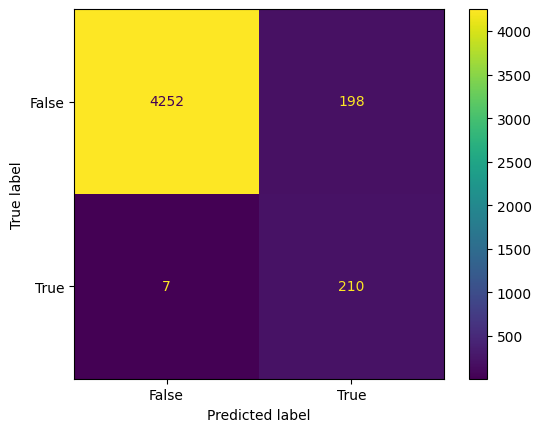

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cv.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cv.best_estimator_, X_train, y_train)

# Instance and Feature Selection 

## CNN

In [39]:
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

np.random.seed(140421)

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

folds = train_data[fold_column].unique()
model = Pipeline([
        ('sampling', CondensedNearestNeighbour(random_state=seed)),
        ('nb', GaussianNB())
    ])

cnn = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn.cv_results_))
print(cnn.best_estimator_, cnn.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.473224      0.094706         0.019841        0.000295   
1        0.409767      0.051081         0.018973        0.000498   
2        0.510570      0.069049         0.018799        0.000820   
3        0.385348      0.069317         0.017811        0.001075   
4        0.416100      0.068227         0.019246        0.000270   
..            ...           ...              ...             ...   
70       0.394620      0.064314         0.018699        0.000763   
71       0.499105      0.073319         0.018420        0.000394   
72       0.386717      0.063721         0.019791        0.001764   
73       0.403893      0.072103         0.019047        0.000799   
74       0.500203      0.074788         0.018121        0.000764   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.655172   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.576923   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.662651   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.651163   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.575540   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.575540   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.554745   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.651163   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.575540   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.554745   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.547170        0.705882        0.750000      0.664556     0.075624   
1         0.409894        0.707317        0.750000      0.611034     0.132479   
2         0.570000        0.707317        0.627737      0.641926     0.050200   
3         0.670520        0.705882        0.750000      0.694391     0.037626   
4         0.426471        0.707317        0.741259      0.612646     0.124038   
..             ...             ...             ...           ...          ...   
70        0.537037        0.725000        0.723404      0.640245     0.085055   
71        0.600000        0.613333        0.693548      0.615407     0.050069   
72        0.678363        0.722892        0.732394      0.696203     0.033049   
73        0.539535        0.725000        0.723404      0.640870     0.084301   
74        0.600000        0.613333        0.693548      0.615407     0.050069   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             25            0.919355            0.935484  ...   
1             75            0.725806            0.935484  ...   
2             26            0.887097            0.919355  ...   
3             19            0.903226            0.935484  ...   
4             74            0.645161            0.935484  ...   
..           ...                 ...                 ...  ...   
70            28            0.645161            0.935484  ...   
71            58            0.612903            0.774194  ...   
72             1            0.9

Pipeline(steps=[('sampling',
                 CondensedNearestNeighbour(n_neighbors=1, random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(8.750125e-08)))]) 0.6962028240648332


                 False        True  accuracy    macro avg  weighted avg
precision     0.996065    0.576369   0.96486     0.786217      0.976550
recall        0.966966    0.921659   0.96486     0.944313      0.964860
f1-score      0.981300    0.709220   0.96486     0.845260      0.968649
support    4450.000000  217.000000   0.96486  4667.000000   4667.000000


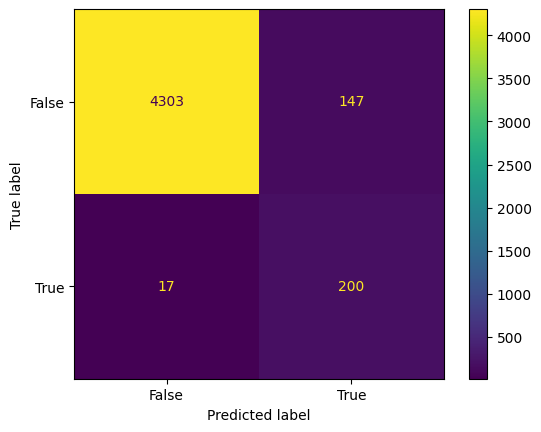

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn.best_estimator_, X_train, y_train)

## SmoteTomek

In [41]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import numpy as np

np.random.seed(140421)


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

folds = train_data[fold_column].unique()
model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('nb', GaussianNB())
    ])

smt = GridSearchCV(
  estimator = model, 
  param_grid={
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

smt.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(smt.cv_results_))
print(smt.best_estimator_, smt.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.236354      0.025802         0.019429        0.000535   
1        0.345081      0.081910         0.019711        0.000496   
2        0.281013      0.015202         0.019587        0.000971   
3        0.258862      0.021936         0.019037        0.000153   
4        0.268630      0.056989         0.019207        0.000959   
5        0.257634      0.066877         0.018881        0.000733   
6        0.279803      0.009370         0.019611        0.000473   
7        0.299438      0.036927         0.018684        0.000547   
8        0.275021      0.059161         0.018495        0.000717   
9        0.269359      0.048381         0.019078        0.001568   
10       0.259458      0.054979         0.019932        0.001260   
11       0.276257      0.051850         0.019259        0.000522   
12       0.290292      0.037264         0.018624        0.001104   
13       0.266355      0.052158         0.018950        0.001115   
14       0.294472      0.024203         0.020536        0.002286   
15       0.234395      0.035190         0.019570        0.000742   
16       0.254373      0.073085         0.019029        0.000631   
17       0.268848      0.060887         0.018844        0.000350   
18       0.243415      0.031395         0.019143        0.000445   
19       0.286993      0.060954         0.021140        0.003677   
20       0.258604      0.035870         0.020093        0.001641   
21       0.295549      0.043730         0.018204        0.001061   
22       0.275562      0.010347         0.019777        0.003248   
23       0.277767      0.016995         0.018692        0.000850   
24       0.272156      0.024604         0.018439        0.000832   

    param_nb__var_smoothing                                         params  \
0              1.000000e-11                   {'nb__var_smoothing': 1e-11}   
1              4.176250e-09             {'nb__var_smoothing': 4.17625e-09}   
2              8.342500e-09              {'nb__var_smoothing': 8.3425e-09}   
3              1.250875e-08  {'nb__var_smoothing': 1.2508750000000001e-08}   
4              1.667500e-08  {'nb__var_smoothing': 1.6675000000000002e-08}   
5              2.084125e-08            {'nb__var_smoothing': 2.084125e-08}   
6              2.500750e-08  {'nb__var_smoothing': 2.5007500000000004e-08}   
7              2.917375e-08  {'nb__var_smoothing': 2.9173750000000003e-08}   
8              3.334000e-08               {'nb__var_smoothing': 3.334e-08}   
9              3.750625e-08            {'nb__var_smoothing': 3.750625e-08}   
10             4.167250e-08             {'nb__var_smoothing': 4.16725e-08}   
11             4.583875e-08            {'nb__var_smoothing': 4.583875e-08}   
12             5.000500e-08  {'nb__var_smoothing': 5.0005000000000003e-08}   
13             5.417125e-08            {'nb__var_smoothing': 5.417125e-08}   
14             5.833750e-08             {'nb__var_smoothing': 5.83375e-08}   
15             6.250375e-08            {'nb__var_smoothing': 6.250375e-08}   
16             6.667000e-08               {'nb__var_smoothing': 6.667e-08}   
17             7.083625e-08   {'nb__var_smoothing': 7.083625000000001e-08}   
18             7.500250e-08             {'nb__var_smoothing': 7.50025e-08}   
19             7.916875e-08            {'nb__var_smoothing': 7.916875e-08}   
20             8.333500e-08              {'nb__var_smoothing': 8.3335e-08}   
21             8.750125e-08            {'nb__var_smoothing': 8.750125e-08}   
22             9.166750e-08             {'nb__var_smoothing': 9.16675e-08}   
23             9.583375e-08            {'nb__var_smoothing': 9.583375e-08}   
24             1.000000e-07                   {'nb__var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.662983        0.641304        0.688889        0.697674   
1         0.662983        0.651934        0.696629        0.705882

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(4.17625e-09)))]) 0.6793571733740364


                 False        True  accuracy    macro avg  weighted avg
precision     0.998356    0.514706  0.956075     0.756531      0.975868
recall        0.955506    0.967742  0.956075     0.961624      0.956075
f1-score      0.976461    0.672000  0.956075     0.824231      0.962305
support    4450.000000  217.000000  0.956075  4667.000000   4667.000000


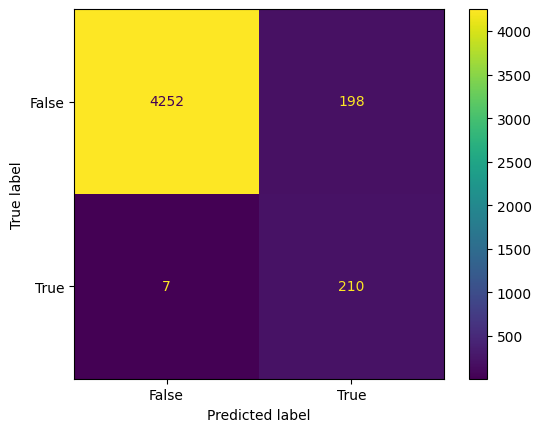

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = smt.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(smt.best_estimator_, X_train, y_train)

## MRMR

In [43]:
MRMR = [ 
  "Towers_mean", 
  "DV_eletric_var",
  "DV_pressure_median",
  "TP2_max",
  "Towers_median",        
  "Reservoirs_max",
  "DV_eletric_min",       
  "Pressure_switch_min", 
  "Motor_current_var",
  "Towers_var",
  "LPS_min",
  "DV_pressure_min",
  "Towers_min",
  "TP2_median", 
  "Oil_level_max",
  "Reservoirs_mean",
  "DV_pressure_mean",
  "Oil_temperature_min",
  "Oil_temperature_var",  
  "DV_eletric_median",
  "Caudal_impulses_max",
  "DV_pressure_var", 
  "LPS_max"              ,
  "H1_max",
  "Motor_current_max",
  "Motor_current_median",
  "COMP_min",
  # "TP2_var",
  # "DV_eletric_mean",      
  # "TP3_var",
  # "Reservoirs_median",
  # "H1_median",
]

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()

mrmr = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(mrmr.cv_results_))
print(mrmr.best_estimator_, mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.005547      0.000782         0.016042        0.000508   
1        0.005098      0.000122         0.016868        0.000647   
2        0.005627      0.000521         0.016627        0.000398   
3        0.005100      0.000235         0.015873        0.000413   
4        0.004934      0.000152         0.016134        0.000268   
5        0.005086      0.000520         0.015885        0.000152   
6        0.005207      0.000546         0.016456        0.000307   
7        0.004926      0.000198         0.016047        0.000490   
8        0.006286      0.001269         0.019498        0.002832   
9        0.005015      0.000329         0.016156        0.000596   
10       0.005341      0.000426         0.017710        0.000706   
11       0.005727      0.000486         0.017811        0.000845   
12       0.007584      0.001776         0.024821        0.004205   
13       0.008637      0.000997         0.024742        0.004615   
14       0.004902      0.000303         0.015906        0.000269   
15       0.004754      0.000195         0.015898        0.000240   
16       0.005057      0.000466         0.016673        0.001446   
17       0.006987      0.000445         0.020637        0.001686   
18       0.006428      0.000409         0.022334        0.002414   
19       0.005742      0.000906         0.018194        0.002743   
20       0.005016      0.000518         0.016184        0.000728   
21       0.005048      0.000603         0.016444        0.000439   
22       0.004856      0.000241         0.017257        0.001790   
23       0.005233      0.000395         0.016440        0.000351   
24       0.005455      0.000586         0.016730        0.000440   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.677778        0.641304        0.696629        0.705202   
1         0.681564        0.641304        0.696629        0.713450   
2         0.681564        0.641304        0.696629        0.713450   
3         0.681564        0.641304        0.696629        0.713450   
4         0.681564        0.641304        0.696629        0.7134

GaussianNB(var_smoothing=np.float64(7.083625000000001e-08)) 0.6862652767512817


                 False        True  accuracy    macro avg  weighted avg
precision     0.998827    0.523457  0.957574     0.761142      0.976724
recall        0.956629    0.976959  0.957574     0.966794      0.957574
f1-score      0.977273    0.681672  0.957574     0.829472      0.963528
support    4450.000000  217.000000  0.957574  4667.000000   4667.000000


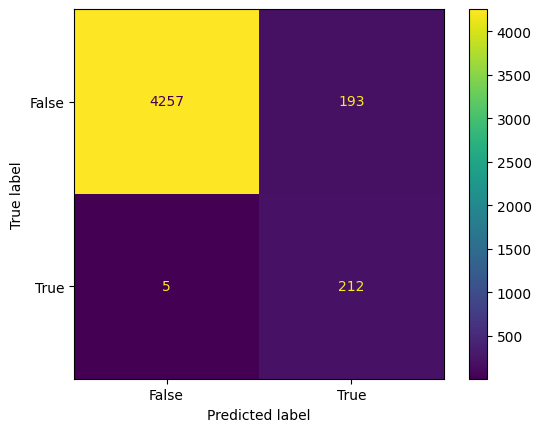

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = mrmr.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(mrmr.best_estimator_, X_train, y_train)

## CHI-Squared

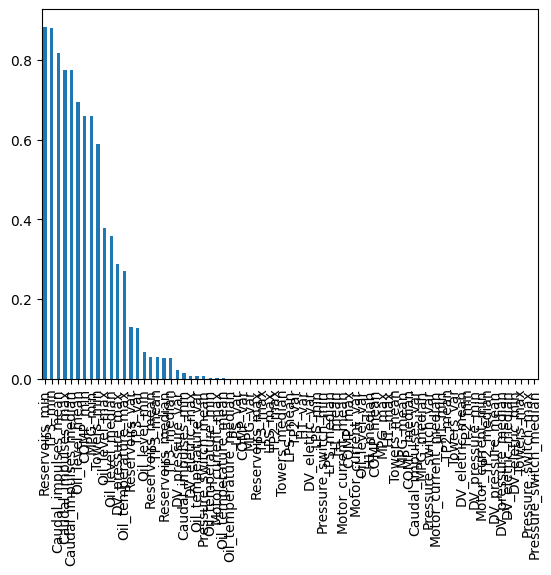

Index(['TP2_mean', 'TP2_max', 'TP2_min', 'TP2_median', 'TP2_var', 'TP3_max',
       'H1_mean', 'H1_max', 'H1_min', 'H1_median', 'H1_var',
       'DV_pressure_mean', 'DV_pressure_min', 'DV_pressure_median',
       'DV_pressure_var', 'Reservoirs_max', 'Oil_temperature_mean',
       'Oil_temperature_min', 'Oil_temperature_median', 'Oil_temperature_var',
       'Motor_current_mean', 'Motor_current_max', 'Motor_current_min',
       'Motor_current_median', 'Motor_current_var', 'COMP_mean', 'COMP_max',
       'COMP_median', 'COMP_var', 'DV_eletric_mean', 'DV_eletric_max',
       'DV_eletric_min', 'DV_eletric_median', 'DV_eletric_var', 'Towers_mean',
       'Towers_median', 'Towers_var', 'MPG_mean', 'MPG_max', 'MPG_median',
       'MPG_var', 'LPS_mean', 'LPS_max', 'LPS_min', 'LPS_median', 'LPS_var',
       'Pressure_switch_mean', 'Pressure_switch_min', 'Pressure_switch_var',
       'Oil_level_var', 'Caudal_impulses_min', 'Caudal_impulses_var'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.008048      0.000541         0.016623        0.000286   
1        0.007221      0.000385         0.017311        0.000458   
2        0.007554      0.000555         0.016787        0.000621   
3        0.007533      0.000324         0.016655        0.000200   
4        0.009424      0.001394         0.019062        0.002387   
5        0.007554      0.000532         0.016771        0.000628   
6        0.007782      0.000474         0.016581        0.000212   
7        0.007711      0.000497         0.016752        0.000309   
8        0.007545      0.000565         0.016244        0.000269   
9        0.007532      0.000559         0.016362        0.000083   
10       0.007649      0.000407         0.016697        0.000252   
11       0.007314      0.000316         0.016258        0.000265   
12       0.008248      0.000531         0.018113        0.000529   
13       0.009546      0.000637         0.018760        0.000499   
14       0.009020      0.001724         0.019115        0.002376   
15       0.007826      0.000395         0.016672        0.000229   
16       0.007639      0.000122         0.016644        0.000396   
17       0.007325      0.000285         0.016704        0.000441   
18       0.007299      0.000655         0.016573        0.000312   
19       0.007432      0.000529         0.016624        0.000153   
20       0.007369      0.000398         0.016759        0.000461   
21       0.007216      0.000453         0.016375        0.000191   
22       0.007450      0.000268         0.016598        0.000458   
23       0.007125      0.000102         0.017376        0.000723   
24       0.007033      0.000331         0.016948        0.000292   

    param_var_smoothing                                     params  \
0          1.000000e-11                   {'var_smoothing': 1e-11}   
1          4.176250e-09             {'var_smoothing': 4.17625e-09}   
2          8.342500e-09              {'var_smoothing': 8.3425e-09}   
3          1.250875e-08  {'var_smoothing': 1.2508750000000001e-08}   
4          1.667500e-08  {'var_smoothing': 1.6675000000000002e-08}   
5          2.084125e-08            {'var_smoothing': 2.084125e-08}   
6          2.500750e-08  {'var_smoothing': 2.5007500000000004e-08}   
7          2.917375e-08  {'var_smoothing': 2.9173750000000003e-08}   
8          3.334000e-08               {'var_smoothing': 3.334e-08}   
9          3.750625e-08            {'var_smoothing': 3.750625e-08}   
10         4.167250e-08             {'var_smoothing': 4.16725e-08}   
11         4.583875e-08            {'var_smoothing': 4.583875e-08}   
12         5.000500e-08  {'var_smoothing': 5.0005000000000003e-08}   
13         5.417125e-08            {'var_smoothing': 5.417125e-08}   
14         5.833750e-08             {'var_smoothing': 5.83375e-08}   
15         6.250375e-08            {'var_smoothing': 6.250375e-08}   
16         6.667000e-08               {'var_smoothing': 6.667e-08}   
17         7.083625e-08   {'var_smoothing': 7.083625000000001e-08}   
18         7.500250e-08             {'var_smoothing': 7.50025e-08}   
19         7.916875e-08            {'var_smoothing': 7.916875e-08}   
20         8.333500e-08              {'var_smoothing': 8.3335e-08}   
21         8.750125e-08            {'var_smoothing': 8.750125e-08}   
22         9.166750e-08             {'var_smoothing': 9.16675e-08}   
23         9.583375e-08            {'var_smoothing': 9.583375e-08}   
24         1.000000e-07                   {'var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.662983        0.644809        0.704545        0.710059   
1         0.662983        0.644809        0.704545        0.710059   
2         0.662983        0.644809        0.704545        0.710059   
3         0.662983        0.644809        0.704545        0.710059   
4         0.662983        0.644809        0.704545        0.7100

GaussianNB(var_smoothing=np.float64(1e-11)) 0.6805991986817128


In [45]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 
chi_scores = chi2(x_train, y_train)
p_values = pd.Series(chi_scores[1],index = X_train.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()
plt.show()

indexes = chi_scores[1] <= 0.05
columns = X_train.columns
print(columns[indexes])

X_train = X_train.loc[:, indexes]

chi = GridSearchCV(
  estimator = GaussianNB(), 
  param_grid={
    "var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

chi.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(chi.cv_results_))
print(chi.best_estimator_, chi.best_score_)

                 False        True  accuracy    macro avg  weighted avg
precision     0.998357    0.517241  0.956503     0.757799      0.975987
recall        0.955955    0.967742  0.956503     0.961848      0.956503
f1-score      0.976696    0.674157  0.956503     0.825427      0.962629
support    4450.000000  217.000000  0.956503  4667.000000   4667.000000


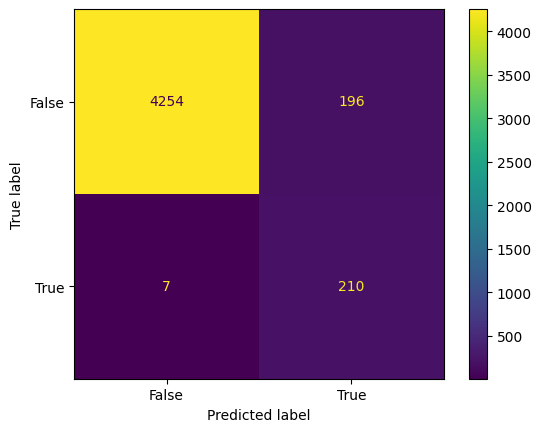

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = chi.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(chi.best_estimator_, X_train, y_train)

## CNN + ChiSquared

In [47]:
import matplotlib.pyplot as plt
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
# feature_columns = MRMR
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 

chi_scores = chi2(x_train, y_train)

indexes = chi_scores[1] <= 0.05
columns = X_train.columns
print(columns[indexes])


X_train = X_train.loc[:, indexes]

model = Pipeline([
        ('sampling', CondensedNearestNeighbour()),
        ('nb', GaussianNB())
    ])

cnn_chi = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn_chi.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn_chi.cv_results_))
print(cnn_chi.best_estimator_, cnn_chi.best_score_)

Index(['TP2_mean', 'TP2_max', 'TP2_min', 'TP2_median', 'TP2_var', 'TP3_max',
       'H1_mean', 'H1_max', 'H1_min', 'H1_median', 'H1_var',
       'DV_pressure_mean', 'DV_pressure_min', 'DV_pressure_median',
       'DV_pressure_var', 'Reservoirs_max', 'Oil_temperature_mean',
       'Oil_temperature_min', 'Oil_temperature_median', 'Oil_temperature_var',
       'Motor_current_mean', 'Motor_current_max', 'Motor_current_min',
       'Motor_current_median', 'Motor_current_var', 'COMP_mean', 'COMP_max',
       'COMP_median', 'COMP_var', 'DV_eletric_mean', 'DV_eletric_max',
       'DV_eletric_min', 'DV_eletric_median', 'DV_eletric_var', 'Towers_mean',
       'Towers_median', 'Towers_var', 'MPG_mean', 'MPG_max', 'MPG_median',
       'MPG_var', 'LPS_mean', 'LPS_max', 'LPS_min', 'LPS_median', 'LPS_var',
       'Pressure_switch_mean', 'Pressure_switch_min', 'Pressure_switch_var',
       'Oil_level_var', 'Caudal_impulses_min', 'Caudal_impulses_var'],
      dtype='object')


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.312490      0.053434         0.021796        0.003311   
1        0.407800      0.074322         0.018324        0.000957   
2        0.425923      0.061108         0.020378        0.002924   
3        0.312782      0.050861         0.017931        0.000349   
4        0.353110      0.060111         0.017375        0.000640   
..            ...           ...              ...             ...   
70       0.385738      0.070294         0.020121        0.002163   
71       0.446149      0.074188         0.018473        0.000460   
72       0.324621      0.046335         0.017416        0.000978   
73       0.369629      0.067455         0.017743        0.000464   
74       0.451220      0.070185         0.017965        0.000805   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.575000   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.579710   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.683761   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.635294   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.579710   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.579710   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.585714   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.635294   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.579710   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.537313   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.682353        0.705882        0.710526      0.668440     0.054995   
1         0.676056        0.683544        0.683333      0.655661     0.043954   
2         0.774194        0.763636        0.767857      0.747362     0.036912   
3         0.682353        0.705882        0.715232      0.684690     0.030933   
4         0.676056        0.692308        0.683333      0.657852     0.045481   
..             ...             ...             ...           ...          ...   
70        0.676056        0.683544        0.683333      0.655661     0.043954   
71        0.666667        0.657143        0.745763      0.663822     0.056718   
72        0.682353        0.705882        0.715232      0.684690     0.030933   
73        0.676056        0.692308        0.683333      0.657852     0.045481   
74        0.657534        0.657143        0.745763      0.649438     0.074120   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             39            0.741935            0.935484  ...   
1             65            0.645161            0.774194  ...   
2              1            0.645161            0.774194  ...   
3             11            0.870968            0.935484  ...   
4             45            0.645161            0.774194  ...   
..           ...                 ...                 ...  ...   
70            65            0.645161            0.774194  ...   
71            42            0.661290            0.774194  ...   
72            11            0.8

Pipeline(steps=[('sampling', CondensedNearestNeighbour(n_neighbors=10)),
                ('nb', GaussianNB(var_smoothing=np.float64(1e-11)))]) 0.7473619346603217


                 False        True  accuracy    macro avg  weighted avg
precision     0.984605    0.596000  0.963788     0.790302      0.966536
recall        0.977303    0.686636  0.963788     0.831970      0.963788
f1-score      0.980941    0.638116  0.963788     0.809528      0.965000
support    4450.000000  217.000000  0.963788  4667.000000   4667.000000


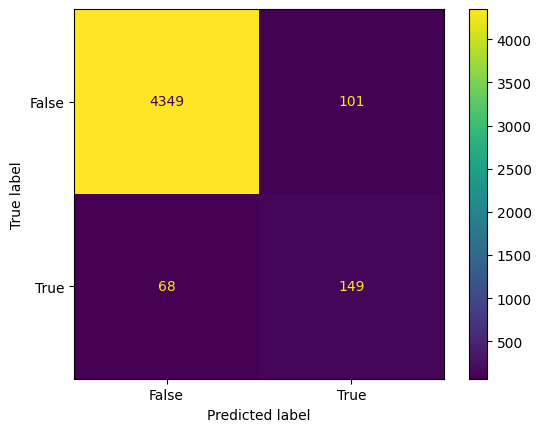

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn_chi.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_chi.best_estimator_, X_train, y_train)

# CNN + MRMR

In [49]:
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR
# feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

model = Pipeline([
        ('sampling', CondensedNearestNeighbour()),
        ('nb', GaussianNB())
    ])

cnn_mrmr = GridSearchCV(
  estimator = model, 
  param_grid={
    "sampling__n_neighbors": [1, 5, 10],
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

cnn_mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(cnn_mrmr.cv_results_))
print(cnn_mrmr.best_estimator_, cnn_mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.387899      0.087409         0.025624        0.008876   
1        0.364642      0.085615         0.018639        0.000450   
2        0.374071      0.042491         0.017436        0.001035   
3        0.336396      0.050210         0.018504        0.000723   
4        0.330517      0.072372         0.018216        0.001342   
..            ...           ...              ...             ...   
70       0.320551      0.072359         0.020296        0.002642   
71       0.391374      0.041306         0.019456        0.002488   
72       0.334465      0.080256         0.017944        0.000686   
73       0.312285      0.063816         0.017580        0.000656   
74       0.378827      0.043410         0.017226        0.001163   

    param_nb__var_smoothing  param_sampling__n_neighbors  \
0              1.000000e-11                            1   
1              1.000000e-11                            5   
2              1.000000e-11                           10   
3              4.176250e-09                            1   
4              4.176250e-09                            5   
..                      ...                          ...   
70             9.583375e-08                            5   
71             9.583375e-08                           10   
72             1.000000e-07                            1   
73             1.000000e-07                            5   
74             1.000000e-07                           10   

                                               params  split0_test_f1  \
0   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.651685   
1   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.690058   
2   {'nb__var_smoothing': 1e-11, 'sampling__n_neig...        0.690058   
3   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.655172   
4   {'nb__var_smoothing': 4.17625e-09, 'sampling__...        0.682353   
..                                                ...             ...   
70  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.591195   
71  {'nb__var_smoothing': 9.583375e-08, 'sampling_...        0.552632   
72  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.655172   
73  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.621118   
74  {'nb__var_smoothing': 1e-07, 'sampling__n_neig...        0.563758   

    split1_test_f1  split2_test_f1  split3_test_f1  mean_test_f1  std_test_f1  \
0         0.678161        0.681818        0.739726      0.687848     0.032130   
1         0.686391        0.425532        0.734694      0.634169     0.121948   
2         0.651934        0.698795        0.734694      0.693870     0.029428   
3         0.409894        0.441176        0.741259      0.561875     0.140133   
4         0.682635        0.697674        0.750000      0.703166     0.027741   
..             ...             ...             ...           ...          ...   
70        0.666667        0.707317        0.741259      0.676609     0.055940   
71        0.685714        0.716049        0.705036      0.664858     0.065697   
72        0.409894        0.697674        0.741259      0.626000     0.128428   
73        0.674419        0.674157        0.732394      0.675522     0.039362   
74        0.680556        0.707317        0.723404      0.668759     0.062524   

    rank_test_f1  split0_test_recall  split1_test_recall  ...  \
0             20            0.935484            0.951613  ...   
1             64            0.951613            0.935484  ...   
2              8            0.951613            0.951613  ...   
3             73            0.919355            0.935484  ...   
4              1            0.935484            0.919355  ...   
..           ...                 ...                 ...  ...   
70            26            0.758065            0.935484  ...   
71            46            0.677419            0.774194  ...   
72            70            0.9

Pipeline(steps=[('sampling', CondensedNearestNeighbour(n_neighbors=5)),
                ('nb', GaussianNB(var_smoothing=np.float64(4.17625e-09)))]) 0.703165522580011


                 False        True  accuracy    macro avg  weighted avg
precision     0.994918    0.576923  0.964645     0.785921      0.975483
recall        0.967865    0.898618  0.964645     0.933241      0.964645
f1-score      0.981205    0.702703  0.964645     0.841954      0.968256
support    4450.000000  217.000000  0.964645  4667.000000   4667.000000


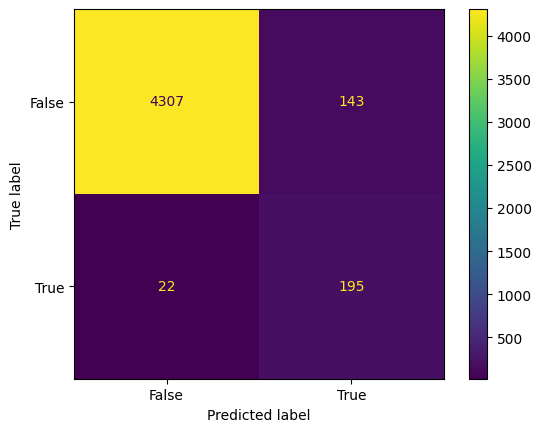

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = cnn_mrmr.best_estimator_.predict(X_train[MRMR])
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_mrmr.best_estimator_, X_train[MRMR], y_train)

## SMOTELinks + MRMR

In [51]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline


# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
feature_columns = MRMR
# feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

def get_cv_iterable(
  folds: list,
  fold_column: str,
  train: pd.DataFrame,
): 
  for fold in folds:
    test_indexes = train[train[fold_column] == fold].index
    train_indexes = train[train[fold_column] != fold].index
    yield (train_indexes, test_indexes)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('nb', GaussianNB())
    ])

smt_mrmr = GridSearchCV(
  estimator = model, 
  param_grid={
    "nb__var_smoothing": np.linspace(1e-11, 1e-7, 25)
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

smt_mrmr.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(smt_mrmr.cv_results_))
print(smt_mrmr.best_estimator_, smt_mrmr.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.155167      0.034659         0.018575        0.000879   
1        0.212326      0.064589         0.021230        0.005910   
2        0.164668      0.013523         0.018714        0.002411   
3        0.172097      0.022795         0.019356        0.002680   
4        0.160830      0.030149         0.019403        0.001116   
5        0.166897      0.042286         0.019687        0.002699   
6        0.168112      0.024088         0.017168        0.000573   
7        0.165467      0.024142         0.018088        0.000537   
8        0.159130      0.028100         0.019171        0.004367   
9        0.160217      0.017538         0.017724        0.000670   
10       0.146789      0.018146         0.018268        0.000633   
11       0.138419      0.031449         0.018366        0.000383   
12       0.163767      0.021487         0.016422        0.000780   
13       0.172478      0.037443         0.019256        0.000823   
14       0.162310      0.032131         0.017400        0.000493   
15       0.175904      0.021642         0.018345        0.000646   
16       0.145918      0.021902         0.018168        0.000294   
17       0.154177      0.044255         0.018563        0.000782   
18       0.143339      0.018057         0.018880        0.001600   
19       0.155051      0.038370         0.017991        0.000289   
20       0.152738      0.033273         0.017574        0.001112   
21       0.146824      0.022165         0.016977        0.001022   
22       0.145486      0.030998         0.017943        0.000656   
23       0.173705      0.021416         0.018010        0.000819   
24       0.167963      0.019102         0.017824        0.001323   

    param_nb__var_smoothing                                         params  \
0              1.000000e-11                   {'nb__var_smoothing': 1e-11}   
1              4.176250e-09             {'nb__var_smoothing': 4.17625e-09}   
2              8.342500e-09              {'nb__var_smoothing': 8.3425e-09}   
3              1.250875e-08  {'nb__var_smoothing': 1.2508750000000001e-08}   
4              1.667500e-08  {'nb__var_smoothing': 1.6675000000000002e-08}   
5              2.084125e-08            {'nb__var_smoothing': 2.084125e-08}   
6              2.500750e-08  {'nb__var_smoothing': 2.5007500000000004e-08}   
7              2.917375e-08  {'nb__var_smoothing': 2.9173750000000003e-08}   
8              3.334000e-08               {'nb__var_smoothing': 3.334e-08}   
9              3.750625e-08            {'nb__var_smoothing': 3.750625e-08}   
10             4.167250e-08             {'nb__var_smoothing': 4.16725e-08}   
11             4.583875e-08            {'nb__var_smoothing': 4.583875e-08}   
12             5.000500e-08  {'nb__var_smoothing': 5.0005000000000003e-08}   
13             5.417125e-08            {'nb__var_smoothing': 5.417125e-08}   
14             5.833750e-08             {'nb__var_smoothing': 5.83375e-08}   
15             6.250375e-08            {'nb__var_smoothing': 6.250375e-08}   
16             6.667000e-08               {'nb__var_smoothing': 6.667e-08}   
17             7.083625e-08   {'nb__var_smoothing': 7.083625000000001e-08}   
18             7.500250e-08             {'nb__var_smoothing': 7.50025e-08}   
19             7.916875e-08            {'nb__var_smoothing': 7.916875e-08}   
20             8.333500e-08              {'nb__var_smoothing': 8.3335e-08}   
21             8.750125e-08            {'nb__var_smoothing': 8.750125e-08}   
22             9.166750e-08             {'nb__var_smoothing': 9.16675e-08}   
23             9.583375e-08            {'nb__var_smoothing': 9.583375e-08}   
24             1.000000e-07                   {'nb__var_smoothing': 1e-07}   

    split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
0         0.674157        0.644809        0.704545        0.714286   
1         0.674157        0.644809        0.712644        0.718563

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('nb', GaussianNB(var_smoothing=np.float64(4.17625e-09)))]) 0.6875431497381504


                 False        True  accuracy    macro avg  weighted avg
precision     0.998826    0.520885  0.957146     0.759855      0.976604
recall        0.956180    0.976959  0.957146     0.966569      0.957146
f1-score      0.977038    0.679487  0.957146     0.828263      0.963203
support    4450.000000  217.000000  0.957146  4667.000000   4667.000000


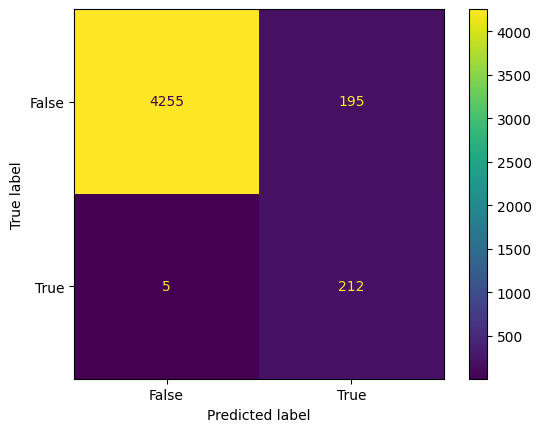

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = smt_mrmr.best_estimator_.predict(X_train[MRMR])
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(smt_mrmr.best_estimator_, X_train[MRMR], y_train)

# Entrenar el modelo de Stacking

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

seed = 140421
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', SVC(random_state=seed)),
    ('nb', GaussianNB())
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)
# Hacemos un GridSearch
scv = GridSearchCV(
  estimator = stack, 
  param_grid = {
    # Decision Tree 
    'dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'svc__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv.cv_results_))
print(scv.best_estimator_, scv.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.671987      0.077183         0.063723        0.015929   
1        0.597930      0.064923         0.048044        0.005410   
2        0.538585      0.072968         0.043982        0.001576   
3        0.622769      0.084014         0.055159        0.008720   
4        0.590015      0.068644         0.049086        0.005973   
5        0.537409      0.056917         0.042409        0.001634   
6        0.626444      0.082328         0.052576        0.005893   
7        0.592257      0.056657         0.049260        0.006111   
8        0.534389      0.057594         0.040797        0.003511   
9        0.628736      0.091568         0.055255        0.009097   
10       0.584613      0.065826         0.052473        0.011742   
11       0.538959      0.051548         0.042331        0.004074   
12       0.536099      0.076408         0.051923        0.005810   
13       0.479316      0.055003         0.047735        0.005609   
14       0.439643      0.060928         0.041165        0.003870   
15       0.507436      0.050501         0.051891        0.006112   
16       0.486926      0.048911         0.047720        0.005446   
17       0.445189      0.059952         0.041583        0.003872   
18       0.525535      0.090511         0.052289        0.005934   
19       0.514959      0.057551         0.048303        0.004630   
20       0.446941      0.060915         0.041290        0.003707   
21       0.520466      0.055975         0.052795        0.006126   
22       0.501771      0.076765         0.048018        0.005787   
23       0.438118      0.046589         0.041178        0.004007   

   param_dt__criterion param_dt__max_depth param_final_estimator__penalty  \
0                 gini                None                           None   
1                 gini                None                           None   
2                 gini                None                           None   
3                 gini                None                             l2   
4                 gini                None                             l2   
5                 gini                None                             l2   
6                 gini                  10                           None   
7                 gini                  10                           None   
8                 gini                  10                           None   
9                 gini                  10                             l2   
10                gini                  10                             l2   
11                gini                  10                             l2   
12             entropy                None                           None   
13             entropy                None                           None   
14             entropy                None                           None   
15             entropy                None                             l2   
16             entropy                None                             l2   
17             entropy                None                             l2   
18             entropy                  10                           None   
19             entropy                  10                           None   
20             entropy                  10                           None   
21             entropy                  10                             l2   
22             entropy                  10                             l2   
23             entropy                  10                             l2   

    param_svc__C                                             params  \
0            0.1  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
1            1.0  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
2           10.0  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
3            0.1  {'dt__criterion': 'gini', 'dt__max_depth': Non...   
4            1.0  {'dt

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=10,
                                                       random_state=140421)),
                               ('svc', SVC(C=0.1, random_state=140421)),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression(penalty=None)) 0.9206006336961015


                 False        True  accuracy    macro avg  weighted avg
precision     0.998429    1.000000    0.9985     0.999215      0.998502
recall        1.000000    0.967742    0.9985     0.983871      0.998500
f1-score      0.999214    0.983607    0.9985     0.991410      0.998488
support    4450.000000  217.000000    0.9985  4667.000000   4667.000000


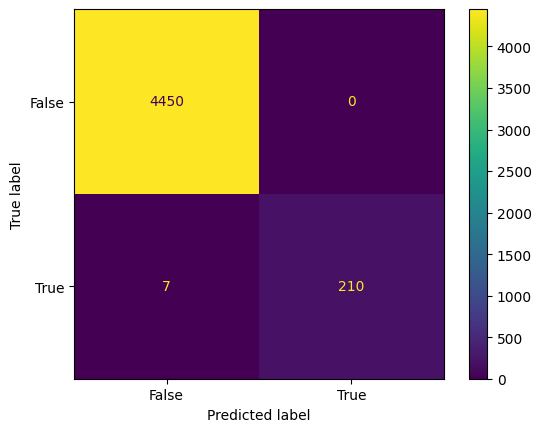

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv.best_estimator_, X_train, y_train)

In [55]:
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv.best_estimator_.final_estimator_.coef_.flatten()  # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         5.306090            54.118029
1        svc         0.793275             8.090796
2         nb         3.705297            37.791175


## Stacking + SMOTETomek

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

seed = 140421
# Utilizamos una versión básica de stacking
estimators = [
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('svc', SVC(random_state=seed)),
    ('nb', GaussianNB())
]
# Con un clasificador final lineal
stack = StackingClassifier(
  estimators=estimators,
  final_estimator=LogisticRegression()
)

model = Pipeline([
        ('sampling', SMOTETomek(random_state=seed)),
        ('stack', stack)
    ])
# Hacemos un GridSearch
scv_smt = GridSearchCV(
  estimator = model, 
  param_grid = {
    # Decision Tree 
    'stack__dt__max_depth': [None, 10],  # Unlimited or moderate depth
    'stack__dt__criterion': ['gini', 'entropy'],  # Gini or Entropy

    # SVC
    'stack__svc__C': [0.1, 1, 10],  

    # Naive Bayes
    # 'nb__solver': [1e-9, 1e-8],  

    # Logistic Regression
    'stack__final_estimator__penalty': [None, 'l2'], # Can focus on 1 model or be more moderate
  },
  cv = get_cv_iterable(folds, fold_column, train_data),
  scoring=[
    "f1",
    "recall",
    "precision", 
    "accuracy"
  ],
  refit="f1",
)

scv_smt.fit(X_train, y_train)
with pd.option_context("display.max_columns", 33):
  display(pd.DataFrame(scv_smt.cv_results_))
print(scv_smt.best_estimator_, scv_smt.best_score_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.855016      0.638526         0.139437        0.021689   
1        2.267284      0.360063         0.085496        0.009201   
2        2.017125      0.381935         0.074884        0.010651   
3        4.074072      0.685857         0.141873        0.023142   
4        2.363331      0.368458         0.087965        0.011709   
5        2.103100      0.338511         0.074053        0.009269   
6        3.768110      0.624727         0.143072        0.022379   
7        2.451622      0.471636         0.087097        0.009935   
8        2.048380      0.313579         0.077297        0.012846   
9        4.063038      0.701158         0.141638        0.021675   
10       2.407188      0.521900         0.086859        0.008483   
11       2.010068      0.275432         0.073314        0.006169   
12       3.719445      0.583379         0.148780        0.027290   
13       2.317261      0.461215         0.091896        0.014235   
14       1.961075      0.274729         0.072210        0.007146   
15       3.764948      0.541496         0.148908        0.027711   
16       2.339281      0.393205         0.089077        0.012058   
17       1.977219      0.348905         0.080015        0.006733   
18       3.844678      0.597581         0.142195        0.021912   
19       2.315627      0.435097         0.087564        0.010002   
20       2.057566      0.346234         0.072784        0.007354   
21       4.075022      0.690253         0.150160        0.024170   
22       2.399707      0.372800         0.086278        0.009748   
23       2.111606      0.327286         0.073840        0.008223   

   param_stack__dt__criterion param_stack__dt__max_depth  \
0                        gini                       None   
1                        gini                       None   
2                        gini                       None   
3                        gini                       None   
4                        gini                       None   
5                        gini                       None   
6                        gini                         10   
7                        gini                         10   
8                        gini                         10   
9                        gini                         10   
10                       gini                         10   
11                       gini                         10   
12                    entropy                       None   
13                    entropy                       None   
14                    entropy                       None   
15                    entropy                       None   
16                    entropy                       None   
17                    entropy                       None   
18                    entropy                         10   
19                    entropy                         10   
20                    entropy                         10   
21                    entropy                         10   
22                    entropy                         10   
23                    entropy                         10   

   param_stack__final_estimator__penalty  param_stack__svc__C  \
0                                   None                  0.1   
1                                   None                  1.0   
2                                   None                 10.0   
3                                     l2                  0.1   
4                                     l2                  1.0   
5                                     l2                 10.0   
6                                   None                  0.1   
7                                   None                  1.0   
8                                   None                 10.0   
9                                     l2                  0.1   
10                                    l2                  1.0   
11                    

Pipeline(steps=[('sampling', SMOTETomek(random_state=140421)),
                ('stack',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(random_state=140421)),
                                                ('svc',
                                                 SVC(C=0.1,
                                                     random_state=140421)),
                                                ('nb', GaussianNB())],
                                    final_estimator=LogisticRegression(penalty=None)))]) 0.9130617414081981


                 False        True  accuracy    macro avg  weighted avg
precision     0.999775    0.995392  0.999571     0.997583      0.999571
recall        0.999775    0.995392  0.999571     0.997583      0.999571
f1-score      0.999775    0.995392  0.999571     0.997583      0.999571
support    4450.000000  217.000000  0.999571  4667.000000   4667.000000


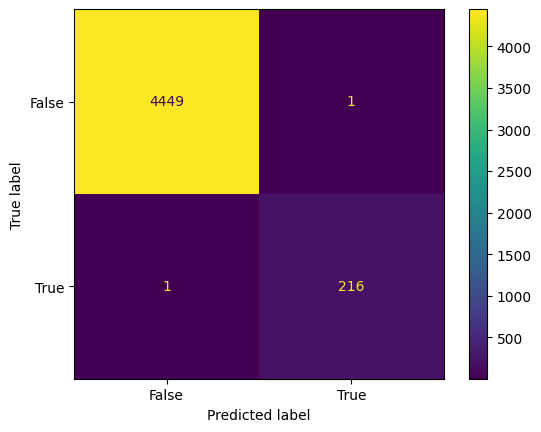

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred_train = scv_smt.best_estimator_.predict(X_train)
print(pd.DataFrame(classification_report(y_train, ypred_train, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_smt.best_estimator_, X_train, y_train)

In [59]:
# Get the coefficients (assuming binary classification for simplicity)
coefficients = scv_smt.best_estimator_.named_steps["stack"].final_estimator_.coef_.flatten() # Flatten if multi-dimensional
abs_coefficients = np.abs(coefficients)  # Get absolute values of coefficients
total_weight = np.sum(abs_coefficients)  # Sum of absolute weights

# Create a DataFrame for better visualization
data = {
    "Model Name": [name for name, _ in stack.estimators],
    "Absolute Weight": coefficients,
    "Relative Weight (%)": (abs_coefficients / total_weight) * 100
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

  Model Name  Absolute Weight  Relative Weight (%)
0         dt         8.492786            75.384928
1        svc         0.932312             8.275530
2         nb         1.840795            16.339542


# Aplicaciones operaciones sobre test con los mejores modelos

                 False       True  accuracy    macro avg  weighted avg
precision     0.985039   0.705128  0.968843     0.845084      0.969673
recall        0.981947   0.743243  0.968843     0.862595      0.968843
f1-score      0.983491   0.723684  0.968843     0.853587      0.969228
support    1274.000000  74.000000  0.968843  1348.000000   1348.000000


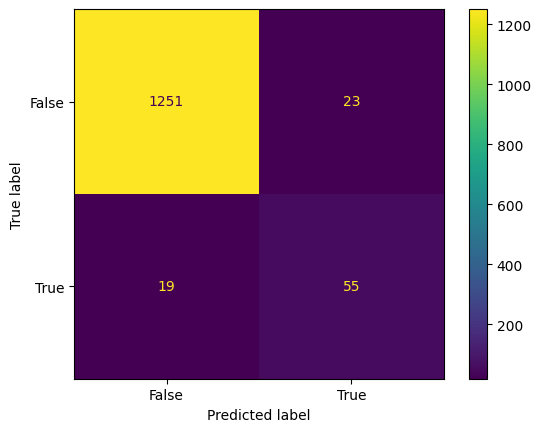

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

# Load the training and testing data
train_data = pd.read_csv('../data/train.csv')
train_data.reset_index()
test_data = pd.read_csv('../data/test.csv')
test_data.reset_index()

target_column = 'is_anomaly'
fold_column = 'fold'
# feature_columns = MRMR
feature_columns = [col for col in train_data.columns if col not in [target_column, fold_column]]

X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Set up cross-validation using the 'folds' column
folds = train_data[fold_column].unique()
x_train = MinMaxScaler().fit_transform(X_train) 
chi_scores = chi2(x_train, y_train)
indexes = chi_scores[1] <= 0.05
columns = X_train.columns

X_test = X_test.loc[:, indexes]
ypred = cnn_chi.best_estimator_.predict(X_test)
print(pd.DataFrame(classification_report(y_test, ypred, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(cnn_chi.best_estimator_, X_test, y_test)

                 False       True  accuracy    macro avg  weighted avg
precision     0.996855   0.921053  0.992582     0.958954      0.992694
recall        0.995290   0.945946  0.992582     0.970618      0.992582
f1-score      0.996072   0.933333  0.992582     0.964703      0.992628
support    1274.000000  74.000000  0.992582  1348.000000   1348.000000


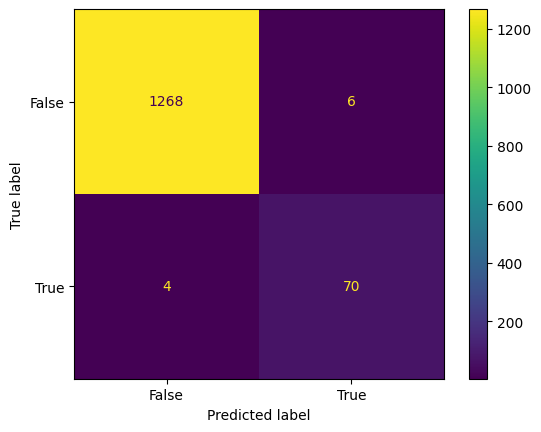

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ypred = scv_smt.best_estimator_.predict(X_test)
print(pd.DataFrame(classification_report(y_test, ypred, output_dict=True)))
_ = ConfusionMatrixDisplay.from_estimator(scv_smt.best_estimator_, X_test, y_test)